## import & load

In [1]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt


import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')

In [3]:
import data.read
importlib.reload(data.read)

<module 'data.read' from '/home/junlim/projects/jitter_recovery/data/read.py'>

In [4]:
df = data.read.df_okx_20231216_1231
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])
all_symbols = df.symbol.unique()

In [5]:
df.tail(3)

,timestamp,symbol,open,high,low,close,volume
3953359,2023-12-31 04:58:00,CSPR-USDT-SWAP,0.04951,0.04951,0.04947,0.04947,41425.0
3953360,2023-12-31 04:58:00,STX-USDT-SWAP,1.43480,1.43500,1.43380,1.43380,3650.0
3953361,2023-12-31 04:58:00,THETA-USDT-SWAP,1.24600,1.24600,1.24600,1.24600,570.0


In [6]:
len([s for s in all_symbols if 'USDT' in s])

157

## single symbol

In [85]:
import algo.jitter_recovery.calculate_longterm
importlib.reload(algo.jitter_recovery.calculate_longterm)

<module 'algo.jitter_recovery.calculate_longterm' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/calculate_longterm.py'>

In [131]:
symbol_investigate = 'SLP-USDT-SWAP'
dfs = dfi.xs(symbol_investigate, level=1)

In [132]:
jitter_recovery_trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(240), 
    0.4, -0.10, 0.05, is_long_term=True)

In [133]:
df_feature = algo.jitter_recovery.calculate.get_feature_df(dfs, jitter_recovery_trading_param.jitter_recover_feature_param)

In [134]:
df_feature[(df_feature.ch_max > 0.2)]

,value,ch_max,ch_min,v_ch_max_is_from,v_ch_min_is_from,v_ch_max_is_to,v_ch_min_is_to,ch_since_max,ch_since_min,distance_max_ch,distance_min_ch
timestamp,,,,,,,,,,,
2024-01-03 15:30:00,0.003328,0.201878,-0.163444,0.002769,0.003310,0.003328,0.002769,0.000000,0.201878,0,198
2024-01-03 15:31:00,0.003351,0.210184,-0.163444,0.002769,0.003310,0.003351,0.002769,0.000000,0.210184,0,199
2024-01-03 15:32:00,0.003344,0.210184,-0.163444,0.002769,0.003310,0.003351,0.002769,-0.002089,0.207656,1,200
2024-01-03 15:33:00,0.003382,0.221380,-0.163444,0.002769,0.003310,0.003382,0.002769,0.000000,0.221380,0,201
2024-01-03 15:34:00,0.003356,0.221380,-0.163444,0.002769,0.003310,0.003382,0.002769,-0.007688,0.211990,1,202
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-03 19:49:00,0.003330,0.258373,-0.235741,0.003344,0.004208,0.004208,0.003216,-0.208650,0.035448,231,43
2024-01-03 19:50:00,0.003312,0.253874,-0.235741,0.003356,0.004208,0.004208,0.003216,-0.212928,0.029851,232,44
2024-01-03 19:51:00,0.003312,0.253874,-0.235741,0.003356,0.004208,0.004208,0.003216,-0.212928,0.029851,233,45


In [135]:
df_trading = algo.jitter_recovery.calculate_longterm.add_trading_columns(df_feature, jitter_recovery_trading_param)

In [136]:
df_trading.columns

Index(['value', 'ch_max', 'ch_min', 'v_ch_max_is_from', 'v_ch_min_is_from',
       'v_ch_max_is_to', 'v_ch_min_is_to', 'ch_since_max', 'ch_since_min',
       'distance_max_ch', 'distance_min_ch', 'in_position', 'value_at_enter',
       'position_changed', 'lowest_since_enter',
       'timedelta_since_position_enter', 'ch_from_enter',
       'ch_from_lowest_since_enter', 'profit_raw', 'profit'],
      dtype='object')

<Axes: xlabel='timestamp'>

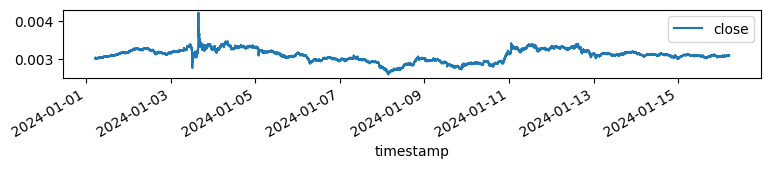

In [137]:
dfs[['close']].plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

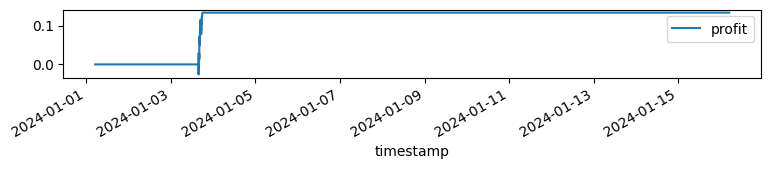

In [138]:
df_trading[['profit']].cumsum().plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

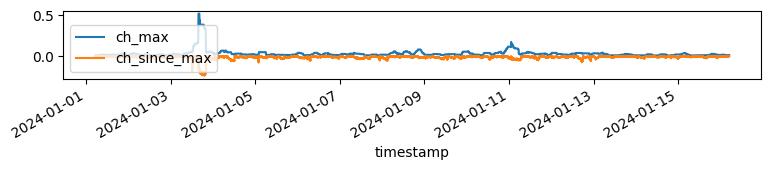

In [139]:
df_trading[['ch_max', 'ch_since_max']].plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

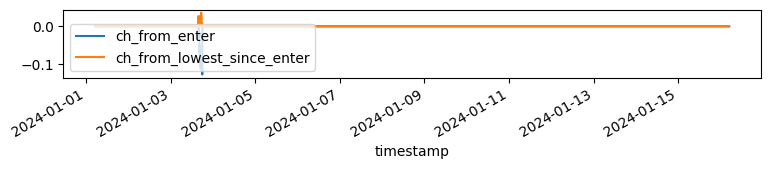

In [140]:
df_trading[['ch_from_enter', 'ch_from_lowest_since_enter']].plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

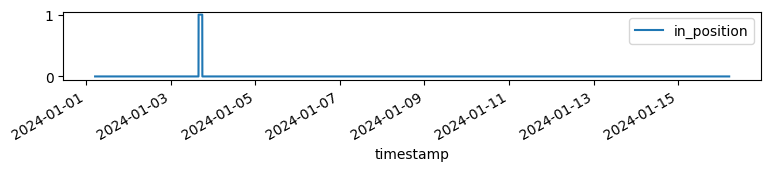

In [141]:
df_trading[['in_position']].plot(figsize=(9,1))

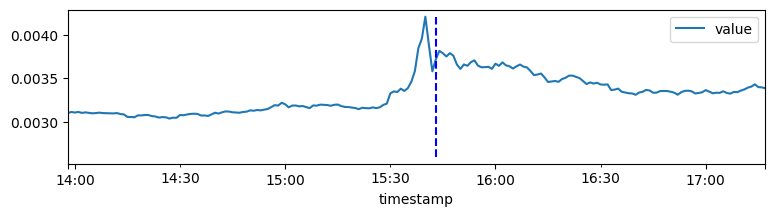

In [142]:
df_plot = df_trading.iloc[3400:3600]
ax = df_plot[['value']].plot(figsize=(9,2))
ymin, ymax = df_trading[['value']].min(), df_trading[['value']].max()

ax.vlines(x=list(df_plot[df_plot.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(df_plot[df_plot.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='dashed', label='enter')

plt.show()

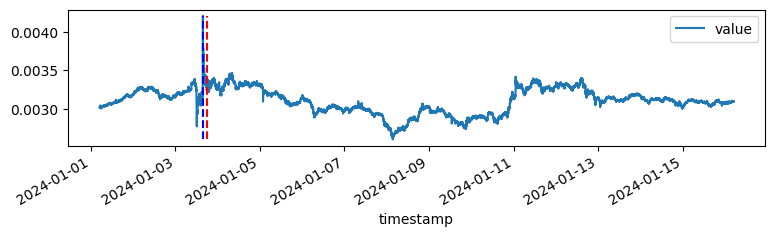

In [144]:
df_plot = df_trading
ax = df_plot[['value']].plot(figsize=(9,2))
ymin, ymax = df_trading[['value']].min(), df_trading[['value']].max()

ax.vlines(x=list(df_plot[df_plot.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(df_plot[df_plot.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='dashed', label='enter')

plt.show()

In [145]:
df_trading[
    (df_trading.index >=  '2024-01-03 15:22:00') &
    (df_trading.index <=  '2024-01-03 15:35:00')
]

,value,ch_max,ch_min,v_ch_max_is_from,v_ch_min_is_from,v_ch_max_is_to,v_ch_min_is_to,ch_since_max,ch_since_min,distance_max_ch,distance_min_ch,in_position,value_at_enter,position_changed,lowest_since_enter,timedelta_since_position_enter,ch_from_enter,ch_from_lowest_since_enter,profit_raw,profit
timestamp,,,,,,,,,,,,,,,,,,,,
2024-01-03 15:22:00,0.003163,0.162875,-0.168718,0.0,0.0,0.0,0.0,-0.017702,0.142290,23,190,0,0.0,0.0,0.0,0,0.0,0.0,-0.0,-0.0
2024-01-03 15:23:00,0.003159,0.162875,-0.168718,0.0,0.0,0.0,0.0,-0.018944,0.140845,24,191,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2024-01-03 15:24:00,0.003157,0.162875,-0.168718,0.0,0.0,0.0,0.0,-0.019565,0.140123,25,192,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2024-01-03 15:25:00,0.003167,0.162875,-0.166968,0.0,0.0,0.0,0.0,-0.016460,0.143734,26,193,0,0.0,0.0,0.0,0,0.0,0.0,-0.0,-0.0
2024-01-03 15:26:00,0.003159,0.162875,-0.166717,0.0,0.0,0.0,0.0,-0.018944,0.140845,27,194,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2024-01-03 15:27:00,0.003168,0.162875,-0.163444,0.0,0.0,0.0,0.0,-0.016149,0.144095,28,195,0,0.0,0.0,0.0,0,0.0,0.0,-0.0,-0.0
2024-01-03 15:28:00,0.003196,0.162875,-0.163444,0.0,0.0,0.0,0.0,-0.007453,0.154207,29,196,0,0.0,0.0,0.0,0,0.0,0.0,-0.0,-0.0
2024-01-03 15:29:00,0.003210,0.162875,-0.163444,0.0,0.0,0.0,0.0,-0.003106,0.159263,30,197,0,0.0,0.0,0.0,0,0.0,0.0,-0.0,-0.0
2024-01-03 15:30:00,0.003328,0.201878,-0.163444,0.0,0.0,0.0,0.0,0.000000,0.201878,0,198,0,0.0,0.0,0.0,0,0.0,0.0,-0.0,-0.0


In [146]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-01-03 15:43:00,0.003720,1,1.0,-0.000000,-0.000000
2024-01-03 17:51:00,0.003246,0,-1.0,0.000008,0.002459


In [147]:
for _, row in dfst_trading[(dfst_trading.position_changed == 1)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row["symbol"] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, in_position: {row["in_position"]}')

2024-01-03 15:43:00, SLP-USDT-SWAP, 0.00372, in_position: 1.0


<Axes: xlabel='timestamp'>

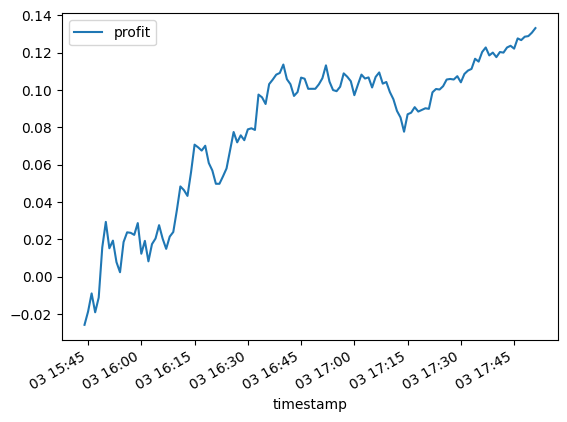

In [148]:
df_trading[(df_trading.in_position.shift() != 0)][['profit']].cumsum().plot()

## multiple symbols

In [7]:
import data.read
importlib.reload(data.read)

<module 'data.read' from '/home/junlim/projects/jitter_recovery/data/read.py'>

In [8]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)

<module 'algo.jitter_recovery.calculate' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/calculate.py'>

In [9]:
jitter_recovery_feature_param_ = algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(50)
jitter_recovery_feature_param = algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(240)

In [10]:
dfst_feature = df.set_index(['symbol', 'timestamp'])
for symbol in all_symbols:
    if 'USDT' not in symbol: continue
    dfs = dfi.xs(symbol, level=1)
    dfs_ = dfs.resample('5min').last()
    df_feature = algo.jitter_recovery.calculate.get_feature_df(dfs_, jitter_recovery_feature_param_)

    print(f'symbol: {symbol}: {len(df_feature[df_feature.ch_max >= 0.30])}')
    if len(df_feature[df_feature.ch_max >= 0.30]) == 0: continue

    df_feature = algo.jitter_recovery.calculate.get_feature_df(dfs, jitter_recovery_feature_param)
    
    for column in df_feature.columns:
        dfst_feature.loc[symbol, column] = df_feature[column].values

symbol: WLD-USDT-SWAP: 38
symbol: STX-USDT-SWAP: 0
symbol: DYDX-USDT-SWAP: 0
symbol: WAVES-USDT-SWAP: 0
symbol: GFT-USDT-SWAP: 0
symbol: CHZ-USDT-SWAP: 0
symbol: XMR-USDT-SWAP: 0
symbol: API3-USDT-SWAP: 0
symbol: ARB-USDT-SWAP: 0
symbol: BCH-USDT-SWAP: 0
symbol: USDC-USDT-SWAP: 0
symbol: MATIC-USDT-SWAP: 0
symbol: FET-USDT-SWAP: 0
symbol: SLP-USDT-SWAP: 0
symbol: GALA-USDT-SWAP: 0
symbol: FTM-USDT-SWAP: 0
symbol: MKR-USDT-SWAP: 0
symbol: GAS-USDT-SWAP: 0
symbol: VRA-USDT-SWAP: 0
symbol: CETUS-USDT-SWAP: 34
symbol: AAVE-USDT-SWAP: 0
symbol: FITFI-USDT-SWAP: 0
symbol: WOO-USDT-SWAP: 0
symbol: TON-USDT-SWAP: 0
symbol: WSM-USDT-SWAP: 0
symbol: CEL-USDT-SWAP: 0
symbol: BAT-USDT-SWAP: 0
symbol: COMP-USDT-SWAP: 0
symbol: BLUR-USDT-SWAP: 0
symbol: CELO-USDT-SWAP: 0
symbol: GMX-USDT-SWAP: 0
symbol: ADA-USDT-SWAP: 0
symbol: NEAR-USDT-SWAP: 0
symbol: DOGE-USDT-SWAP: 0
symbol: ZIL-USDT-SWAP: 0
symbol: PEOPLE-USDT-SWAP: 0
symbol: LDO-USDT-SWAP: 0
symbol: NFT-USDT-SWAP: 0
symbol: FRONT-USDT-SWAP: 0


In [11]:
symbol_with_jumps = [s for s in list(set(list(dfst_feature[dfst_feature.ch_max >= 0.30].index.get_level_values(0)))) if 'USDT' in s]
len(symbol_with_jumps)

8

In [12]:
jitter_recovery_trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(240), 
    0.4, -0.10, 0.05, is_long_term=True)

In [14]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)

<module 'algo.jitter_recovery.calculate' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/calculate.py'>

In [16]:
dfst_trading = df.set_index(['symbol', 'timestamp'])
for symbol in symbol_with_jumps:
    if 'USDT' not in symbol: continue
    dfs = dfi.xs(symbol, level=1)
    print(f'symbol: {symbol}')
    df_feature = algo.jitter_recovery.calculate.get_feature_df(dfs, jitter_recovery_trading_param.jitter_recover_feature_param)
    df_trading = algo.jitter_recovery.calculate.add_trading_columns(df_feature, jitter_recovery_trading_param)
    for column in df_trading.columns:
        dfst_trading.loc[symbol, column] = df_trading[column].values

symbol: KSM-USDT-SWAP
symbol: ICP-USDT-SWAP
symbol: YFII-USDT-SWAP
symbol: PERP-USDT-SWAP
symbol: ACE-USDT-SWAP
symbol: CETUS-USDT-SWAP
symbol: ALPHA-USDT-SWAP
symbol: WLD-USDT-SWAP


<Axes: xlabel='timestamp'>

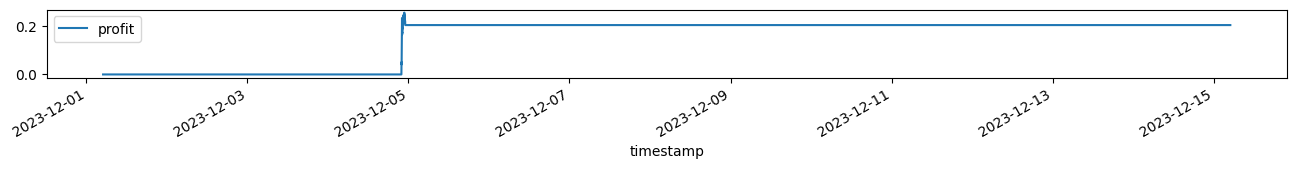

In [17]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

<Axes: xlabel='timestamp'>

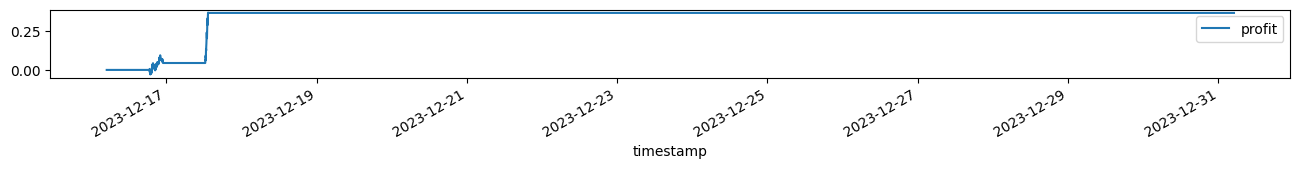

In [28]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

<Axes: xlabel='timestamp'>

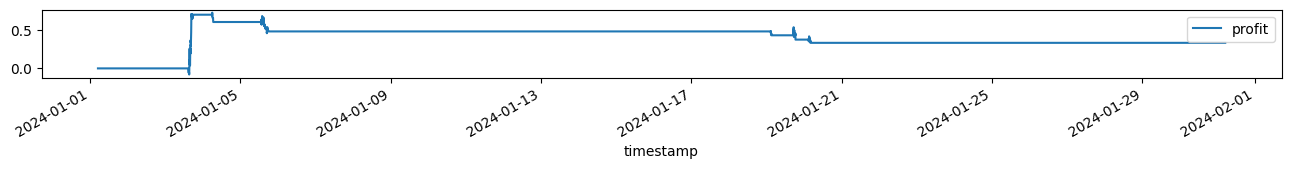

In [24]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

In [108]:
dfst_trading[['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
TRB-USDT-SWAP,-0.072443
1INCH-USD-SWAP,0.000000
MINA-USDT-SWAP,0.000000
MKR-USDT-SWAP,0.000000
MOVR-USDT-SWAP,0.000000
...,...
ETHW-USDT-SWAP,0.000000
EGLD-USDT-SWAP,0.000000
CORE-USDT-SWAP,0.065841


In [109]:
#dfst_feature.xs('PEOPLE-USDT-SWAP').loc['2024-01-07 16:38:00']

In [110]:
'''
{
'value': 0.008794, 
'ch_largest': 0.2634039043167446, 'ch_smallest': 0.0, 
'ch_since_largest': -0.043090315560391786, 'ch_since_smallest': 0.20896343139950505, 
'distance_largest_ch': 31, 'distance_smallest_ch': 59
}
'''

"\n{\n'value': 0.008794, \n'ch_largest': 0.2634039043167446, 'ch_smallest': 0.0, \n'ch_since_largest': -0.043090315560391786, 'ch_since_smallest': 0.20896343139950505, \n'distance_largest_ch': 31, 'distance_smallest_ch': 59\n}\n"

In [111]:
dfst_trading[(dfst_trading.ch_max > 0.15) & (dfst_trading.ch_since_max < -0.01)]

open     high      low    close  \
symbol        timestamp                                                 
TRB-USDT-SWAP 2024-01-01 05:29:00  228.670  230.000  221.790  223.690   
              2024-01-01 05:31:00  241.590  245.340  203.470  218.030   
              2024-01-01 05:32:00  218.260  226.550  208.000  209.600   
              2024-01-01 05:33:00  209.460  221.980  206.260  221.770   
              2024-01-01 05:34:00  221.980  223.850  209.190  210.520   
...                                    ...      ...      ...      ...   
ENS-USDT-SWAP 2024-01-14 05:45:00   26.581   26.724   26.520   26.659   
              2024-01-14 05:46:00   26.654   26.848   26.639   26.762   
              2024-01-14 05:47:00   26.769   26.798   26.743   26.759   
              2024-01-14 05:48:00   26.759   26.849   26.751   26.827   
              2024-01-14 05:49:00   26.827   26.850   26.750   26.813   

                                    volume    value    ch_max    ch_min  \
symbol        timestamp                                                   
TRB-USDT-SWAP 2024-01-01 05:29:00  36996.1  223.690  0.265818 -0.021952   
              2024-01-01 05:31:00  77890.4  218.030  0.338555 -0.098342   
              2024-01-01 05:32:00  47677.0  209.600  0.338555 -0.133204   
              2024-01-01 05:33:00  34243.8  221.770  0.338555 -0.133204   
              2024-01-01 05:34:00  32636.3  210.520  0.338555 -0.133204   
...                                    ...      ...       ...       ...   
ENS-USDT-SWAP 2024-01-14 05:45:00  14310.3   26.659  0.150972 -0.078468   
              2024-01-14 05:46:00  27735.9   26.762  0.150972 -0.078468   
              2024-01-14 05:47:00   5575.0   26.759  0.150249 -0.078468   
              2024-01-14 05:48:00  10004.3   26.827  0.150249 -0.078468   
              2024-01-14 05:49:00  14960.3   26.813  0.150249 -0.078468   

                                   v_ch_max_is_from  v_ch_min_is_from  ...  \
symbol        timestamp                                                ...   
TRB-USDT-SWAP 2024-01-01 05:29:00               0.0               0.0  ...   
              2024-01-01 05:31:00               0.0               0.0  ...   
              2024-01-01 05:32:00               0.0               0.0  ...   
              2024-01-01 05:33:00               0.0               0.0  ...   
              2024-01-01 05:34:00               0.0               0.0  ...   
...                                             ...               ...  ...   
ENS-USDT-SWAP 2024-01-14 05:45:00               0.0               0.0  ...   
              2024-01-14 05:46:00               0.0               0.0  ...   
              2024-01-14 05:47:00               0.0               0.0  ...   
              2024-01-14 05:48:00               0.0               0.0  ...   
              2024-01-14 05:49:00               0.0               0.0  ...   

                                   distance_min_ch  in_position  \
symbol        timestamp                                           
TRB-USDT-SWAP 2024-01-01 05:29:00             16.0          0.0   
              2024-01-01 05:31:00              0.0          0.0   
              2024-01-01 05:32:00              0.0          0.0   
              2024-01-01 05:33:00              1.0          0.0   
              2024-01-01 05:34:00              2.0          0.0   
...                                            ...          ...   
ENS-USDT-SWAP 2024-01-14 05:45:00             49.0          0.0   
              2024-01-14 05:46:00             50.0          0.0   
              2024-01-14 05:47:00             51.0          0.0   
              2024-01-14 05:48:00             52.0          0.0   
              2024-01-14 05:49:00             53.0          0.0   

                                   value_at_enter  position_changed  \
symbol        timestamp                                               
TRB-USDT-SWAP 2024-01-01 05:29:00             0.0               0.0   
            

In [112]:
dfst_trading[(dfst_trading.ch_max > 0.15) & (dfst_trading.ch_since_max < 0)].loc[symbol_with_jumps[0]]

,open,high,low,close,volume,value,ch_max,ch_min,v_ch_max_is_from,v_ch_min_is_from,...,distance_min_ch,in_position,value_at_enter,position_changed,lowest_since_enter,timedelta_since_position_enter,ch_from_enter,ch_from_lowest_since_enter,profit_raw,profit
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-03 12:12:00,0.000261,0.000263,0.000251,0.000255,540620000.0,0.000255,0.169203,-0.401874,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-03 12:16:00,0.000273,0.000276,0.000256,0.000258,898330000.0,0.000258,0.217099,-0.401874,0.0,0.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-03 12:19:00,0.000283,0.000285,0.000263,0.000269,676940000.0,0.000269,0.271710,-0.401874,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-03 12:20:00,0.000269,0.000280,0.000267,0.000279,528270000.0,0.000279,0.271710,-0.401874,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
2024-01-03 12:21:00,0.000278,0.000285,0.000278,0.000283,181200000.0,0.000283,0.271710,-0.401874,0.0,0.0,...,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-11 00:57:00,0.000378,0.000378,0.000377,0.000377,7780000.0,0.000377,0.158351,-0.032698,0.0,0.0,...,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-11 00:58:00,0.000377,0.000378,0.000377,0.000378,3250000.0,0.000378,0.158351,-0.032698,0.0,0.0,...,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
2024-01-11 01:08:00,0.000373,0.000373,0.000369,0.000371,61000000.0,0.000371,0.151128,-0.043848,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 15:13:00, CORE-USDT-SWAP, 0.625, position_changed: 1.0
2024-01-03 15:20:00, CORE-USDT-SWAP, 0.5652, position_changed: -1.0
2024-01-03 15:21:00, CORE-USDT-SWAP, 0.595, position_changed: 1.0
2024-01-03 15:23:00, PEOPLE-USDT-SWAP, 0.05187, position_changed: 1.0
2024-01-03 15:34:00, PEOPLE-USDT-SWAP, 0.04607, position_changed: -1.0
2024-01-03 15:35:00, PEOPLE-USDT-SWAP, 0.04513, position_changed: 1.0
2024-01-03 15:36:00, PEOPLE-USDT-SWAP, 0.04879, position_changed: -1.0
2024-01-03 15:37:00, PEOPLE-USDT-SWAP, 0.04874, position_changed: 1.0
2024-01-03 15:43:00, SLP-USDT-SWAP, 0.00372, position_changed: 1.0
2024-01-03 15:48:00, PEOPLE-USDT-SWAP, 0.04895, position_changed: -1.0
2024-01-03 15:49:00, PEOPLE-USDT-SWAP, 0.05137, position_changed: 1.0
2024-01-03 15:53:00, CORE-USDT-SWAP, 0.6123, position_changed: -1.0
2024-01-03 16:40:00, PEOPLE-USDT-SWAP, 0.02758, position_changed: -1.0
2024-01-03 17:51:00, SLP-USDT-SWAP, 0.003246, position_changed: -1.0
2024-01-04 05:53:00, PEOPLE-USDT